# pytorch DNN 手寫辨識


In [1]:
import numpy as np
import torch
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt
import os
from torchvision import datasets, transforms, utils


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=[0.5], std=[0.5])]
)


In [3]:
train_data = datasets.MNIST(
    root="./data/", transform=transform, train=True, download=True
)

test_data = datasets.MNIST(root="./data/", transform=transform, train=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 111519540.05it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 8762709.33it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 43945298.79it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1288416.66it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
len(test_data)


10000

In [5]:
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=64, shuffle=True, num_workers=2
)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=64, shuffle=True, num_workers=2
)


In [6]:
print(len(train_loader))
print(len(test_loader))


938
157


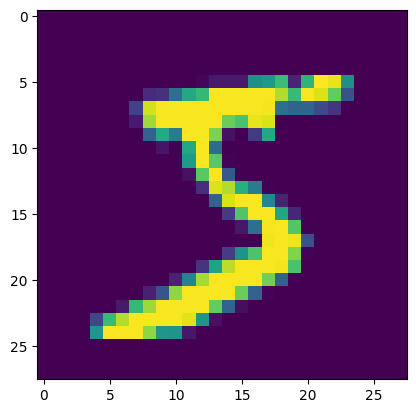

In [7]:
# data_iter = iter(train_loader)
# print(next(data_iter))
oneimg, label = train_data[0]
oneimg = oneimg.numpy().transpose(1, 2, 0)
std = [0.5]
mean = [0.5]
oneimg = oneimg * std + mean
oneimg.resize(28, 28)
plt.imshow(oneimg)
plt.show()
# 從二為數組中生成一張圖片


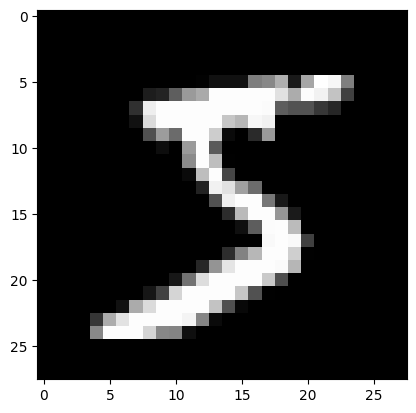

In [8]:
oneimg, label = train_data[0]
grid = utils.make_grid(oneimg)
grid = grid.numpy().transpose(1, 2, 0)
std = [0.5]
mean = [0.5]
grid = grid * std + mean
plt.imshow(grid)
plt.show()
# 從三維中生成一張圖片


tensor(3) tensor(9) tensor(0) tensor(6) tensor(7) tensor(9) tensor(7) tensor(1) 
tensor(8) tensor(4) tensor(2) tensor(6) tensor(9) tensor(6) tensor(4) tensor(7) 
tensor(6) tensor(2) tensor(0) tensor(6) tensor(5) tensor(1) tensor(1) tensor(1) 
tensor(7) tensor(3) tensor(8) tensor(9) tensor(4) tensor(7) tensor(5) tensor(2) 
tensor(9) tensor(0) tensor(9) tensor(6) tensor(1) tensor(3) tensor(7) tensor(0) 
tensor(8) tensor(3) tensor(0) tensor(4) tensor(8) tensor(9) tensor(7) tensor(0) 
tensor(2) tensor(0) tensor(0) tensor(1) tensor(1) tensor(1) tensor(7) tensor(1) 
tensor(7) tensor(7) tensor(0) tensor(2) tensor(9) tensor(9) tensor(1) tensor(6) 


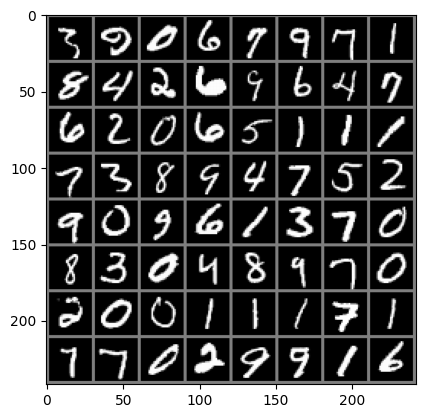

In [9]:
images, lables = next(iter(train_loader))
img = utils.make_grid(images)
# transpose 轉置函數(x=0,y=1,z=2),新的x是原来的y軸大小，新的y是原来的z軸大小，新的z是原来的x大小
# 相當於把x=1這個一道最後面去。
img = img.numpy().transpose(1, 2, 0)
std = [0.5]
mean = [0.5]
img = img * std + mean
for i in range(64):
    print(lables[i], end=" ")
    i += 1
    if i % 8 == 0:
        print(end="\n")
plt.imshow(img)
plt.show()


In [10]:
import torch.nn.functional as F


class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 1024)  # MNIST images are 28x28
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input data
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


net = DNN()


In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)


In [12]:
train_accs = []
train_loss = []
test_accs = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
for epoch in range(3):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):  # 0是下標起始位置默認為0
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print("[%d,%5d] loss :%.3f" % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
        train_loss.append(loss.item())

        correct = 0
        total = 0
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)  # labels 的長度
        correct = (predicted == labels).sum().item()  # 預測正確的數字
        train_accs.append(100 * correct / total)

print("Finished Training")


[1,  100] loss :1.331
[1,  200] loss :0.482
[1,  300] loss :0.399
[1,  400] loss :0.368
[1,  500] loss :0.370
[1,  600] loss :0.378
[1,  700] loss :0.374
[1,  800] loss :0.322
[1,  900] loss :0.354
[2,  100] loss :0.309
[2,  200] loss :0.359
[2,  300] loss :0.332
[2,  400] loss :0.321
[2,  500] loss :0.318
[2,  600] loss :0.271
[2,  700] loss :0.283
[2,  800] loss :0.283
[2,  900] loss :0.272
[3,  100] loss :0.276
[3,  200] loss :0.290
[3,  300] loss :0.316
[3,  400] loss :0.311
[3,  500] loss :0.276
[3,  600] loss :0.275
[3,  700] loss :0.244
[3,  800] loss :0.278
[3,  900] loss :0.279
Finished Training


In [13]:
PATH = "./mnist_net.pth"
torch.save(net.state_dict(), PATH)


In [14]:
def draw_train_process(title, iters, costs, accs, label_cost, lable_acc):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel("acc(%)", fontsize=20)
    plt.plot(iters, costs, color="red", label=label_cost)
    plt.plot(iters, accs, color="green", label=lable_acc)
    plt.legend()
    plt.grid()
    plt.show()


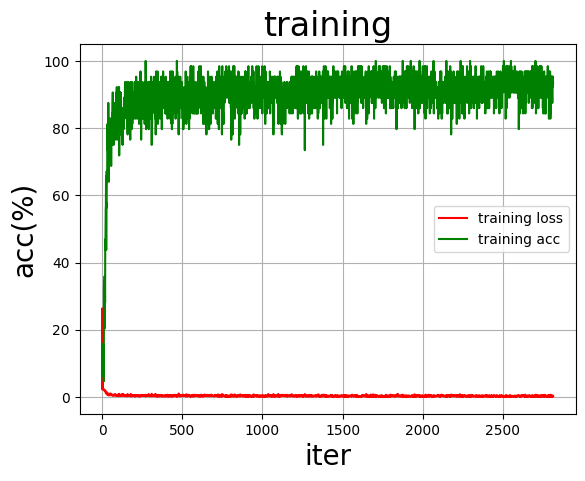

In [15]:
train_iters = range(len(train_accs))
draw_train_process(
    "training", train_iters, train_loss, train_accs, "training loss", "training acc"
)
